# Mounting onto the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing necessary packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from imblearn.pipeline import Pipeline as ImbPipeline

from collections import Counter

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)

# Loading and Modifying the datasets

In [3]:
df_clients = pd.read_excel('/content/drive/MyDrive/Hackaton/Code/clients.xlsx')
df_complaints = pd.read_excel('/content/drive/MyDrive/Hackaton/Code/complaints.xlsx')

In [ ]:
print(df_clients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Including the complaints counts

In [4]:
df_complaints['complaints_count'] = df_complaints.groupby('customerID')['complaint_number'].transform('max')
df_complaints['all_complaints'] = df_complaints.groupby('customerID')['complaint'].transform(list)

In [ ]:
df_complaints.head(10)

,customerID,complaint,complaint_number,complaints_count,all_complaints
0,9565-DJPIB,The streaming TV service frequently buffers or...,1,1,The streaming TV service frequently buffers or...
1,4342-HFXWS,The DSL internet service has been inconsistent...,1,5,The DSL internet service has been inconsistent...
2,4342-HFXWS,The streaming TV service often buffers excessi...,2,5,The streaming TV service often buffers excessi...
3,4342-HFXWS,"Despite having tech support included, it takes...",3,5,"Despite having tech support included, it takes..."
4,4342-HFXWS,The device protection plan I pay for did not c...,4,5,The device protection plan I pay for did not c...
5,4342-HFXWS,"I requested a paper bill for my records, but t...",5,5,"I requested a paper bill for my records, but t..."
6,8988-ECPJR,The internet service has been very inconsisten...,1,3,The internet service has been very inconsisten...
7,8988-ECPJR,I was disappointed to find out that there is n...,2,3,I was disappointed to find out that there is n...
8,8988-ECPJR,The monthly charges are too high for the limit...,3,3,The monthly charges are too high for the limit...
9,1567-DSCIC,The internet speed with your fiber optic servi...,1,2,The internet speed with your fiber optic servi...


In [5]:
temp_complaints = df_complaints.groupby('customerID').agg({
    'complaints_count': 'max',
    'all_complaints': list
    }).reset_index()
print(temp_complaints.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        704 non-null    object
 1   complaints_count  704 non-null    int64 
 2   all_complaints    704 non-null    object
dtypes: int64(1), object(2)
memory usage: 16.6+ KB
None


In [6]:
df_merge=df_clients.merge(temp_complaints,on='customerID', how='left')
print(df_merge.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df_merge['complained']=np.where(~df_merge['complaints_count'].isnull(),1,0)
df_merge['complaints_count']=np.where(df_merge['complaints_count'].isnull(),0, df_merge['complaints_count'])
print(df_merge.head())

df_merge.groupby(['complained','Churn'])['Churn'].count()

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... StreamingMovies  \
0  No phone service             DSL             No  ...              No   
1                No             DSL            Yes  ...              No   
2                No             DSL            Yes  ...              No   
3  No phone service             DSL            Yes  ...              No   
4                No     Fiber optic             No  ...              No   

         Contract PaperlessBilling              PaymentMethod Monthl

complained  Churn
0           No       4895
            Yes      1444
1           No        279
            Yes       425
Name: Churn, dtype: int64

In [8]:
# Convert 'TotalCharges' to numeric (handle errors if there are empty spaces)
df_merge['TotalCharges'] = pd.to_numeric(df_merge['TotalCharges'], errors='coerce')

merge_numeric = df_merge.drop(columns=['customerID', 'all_complaints'], errors='ignore')
merge_numeric.info()
print(merge_numeric.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


# Generating Dummies

In [9]:
merge_numeric = pd.get_dummies(merge_numeric, drop_first=True)

In [10]:
merge_numeric.head()
merge_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   tenure                                 7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   complaints_count                       7043 non-null   float64
 5   complained                             7043 non-null   int64  
 6   gender_Male                            7043 non-null   bool   
 7   Partner_Yes                            7043 non-null   bool   
 8   Dependents_Yes                         7043 non-null   bool   
 9   PhoneService_Yes                       7043 non-null   bool   
 10  MultipleLines_No phone service         7043 non-null   bool   
 11  Mult

# EDA

In [12]:
import pandas as pd

numerical_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
                     'complaints_count']

categorical_columns = ['complained', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
                       'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic',
                       'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
                       'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service',
                       'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes',
                       'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service',
                       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
                       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check',
                       'PaymentMethod_Mailed check']

numerical_stats = merge_numeric.groupby('Churn_Yes')[numerical_columns].agg(
    ['mean', 'std', 'median', 'min', 'max', 'count']
)

categorical_stats = merge_numeric.groupby('Churn_Yes')[categorical_columns].agg(
    ['sum', 'count']
)

categorical_proportions = merge_numeric.groupby('Churn_Yes')[categorical_columns].apply(
    lambda x: x.sum() / x.count()
)

result = pd.concat([numerical_stats, categorical_stats, categorical_proportions], axis=1)

In [ ]:
# print(result)

           (SeniorCitizen, mean)  (SeniorCitizen, std)  \
Churn_Yes                                                
False                   0.128721              0.334923   
True                    0.254682              0.435799   

           (SeniorCitizen, median)  (SeniorCitizen, min)  \
Churn_Yes                                                  
False                          0.0                     0   
True                           0.0                     0   

           (SeniorCitizen, max)  (SeniorCitizen, count)  (tenure, mean)  \
Churn_Yes                                                                 
False                         1                    5174       37.569965   
True                          1                    1869       17.979133   

           (tenure, std)  (tenure, median)  (tenure, min)  ...  \
Churn_Yes                                                  ...   
False          24.113777              38.0              0  ...   
True           19.531123   

# XGBoost

Fill-in `NA` and dividing targe and predictors

In [13]:
merge_numeric['TotalCharges'].fillna(merge_numeric['TotalCharges'].median(), inplace=True)

X = merge_numeric.drop(columns=['Churn_Yes'])
y = merge_numeric['Churn_Yes']

<ipython-input-13-05b65b1283db>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merge_numeric['TotalCharges'].fillna(merge_numeric['TotalCharges'].median(), inplace=True)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

f2_scorer = make_scorer(fbeta_score, beta=2)

selector = RFECV(
    estimator=XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # class balancing to take care of the fact that target variable is unbalances
        random_state=42
    ),
    step=1,
    cv=5,
    scoring=f2_scorer,
    min_features_to_select=5,
    n_jobs=-1
)

pipeline = Pipeline([
    ('select', selector),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # class balancing
        random_state=42
    ))
])

param_grid = {
    'clf__max_depth': [3], #Different tree depth
    'clf__learning_rate': [0.01], # learning rate
    'clf__n_estimators': [200], # number of trees
    'clf__subsample': [0.8] # row sampling fraction per tree
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=5,
    n_jobs=-1,
    refit=True)

grid.fit(X_train, y_train)

best = grid.best_estimator_
y_pred = best.predict(X_test)

print("Best params:", grid.best_params_)
print(f"Selected features: {best.named_steps['select'].n_features_}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"F2 Score:  {fbeta_score(y_test, y_pred, beta=2):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Selected features: 7
Accuracy:  0.7402
Precision: 0.5064
Recall:    0.8422
F1 Score:  0.6325
F2 Score:  0.7436
Confusion Matrix:
 [[728 307]
 [ 59 315]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:40:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Feature importance


Top Features by Importance:
                       Feature  Importance
6            Contract_Two year    0.361811
5            Contract_One year    0.303174
3           InternetService_No    0.095959
2  InternetService_Fiber optic    0.080849
0                       tenure    0.078135
1             complaints_count    0.042520
4          StreamingMovies_Yes    0.037552


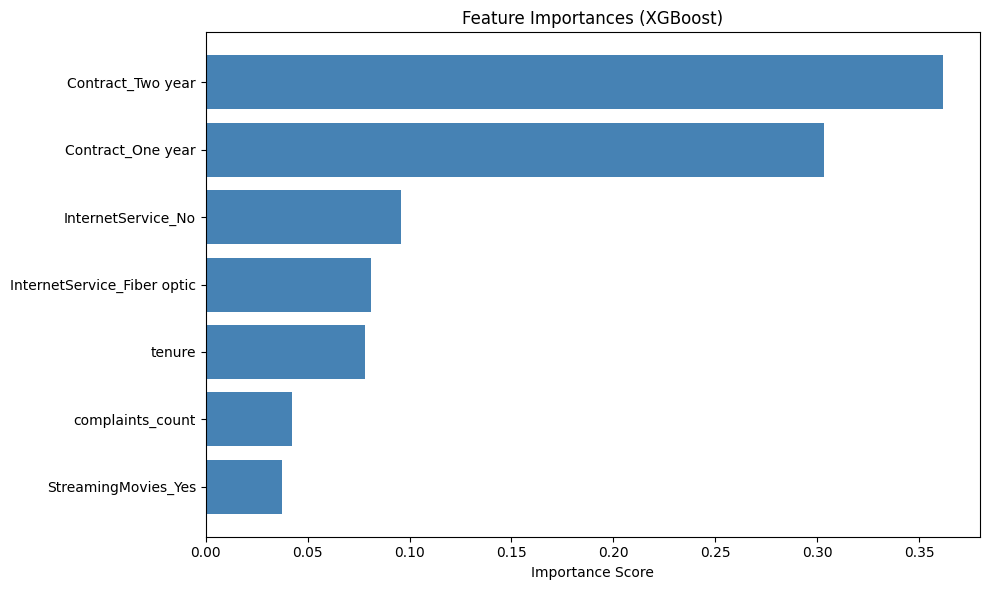

In [15]:
support_mask = best.named_steps['select'].support_
selected_features = X.columns[support_mask]

importances = best.named_steps['clf'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['Feature'],
    feature_importance_df['Importance'],
    color='steelblue'
)
plt.gca().invert_yaxis()
plt.title('Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# ROC & Precision Recall


ROC AUC: 0.8528


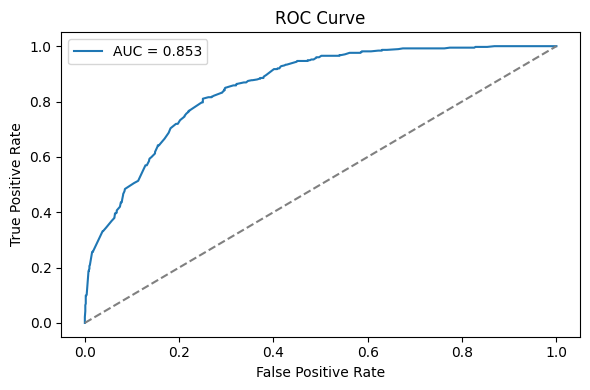

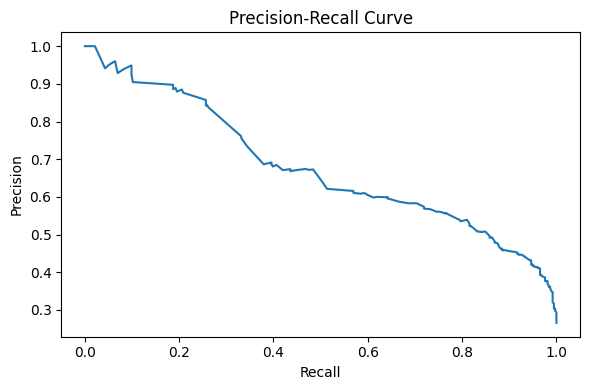

In [16]:
# ROC AUC
y_proba = best.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Precision‑Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‑Recall Curve")
plt.tight_layout()
plt.show()

# Log-Odd Distribution


=== Decile Analysis (Top decile = highest predicted risk) ===
        ChurnRate  Count
Decile                  
9        0.837607    117
8        0.546053    152
7        0.441176    136
6        0.394904    157
5        0.186567    134
4        0.181208    149
3        0.086957    138
2        0.028369    141
1        0.015152    132
0        0.006536    153


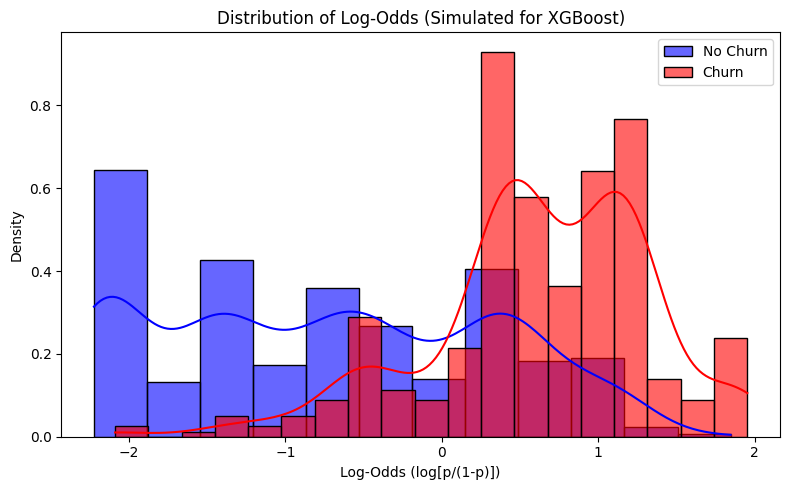

In [17]:
# Get predicted probabilities (of the positive class)
y_proba = best.predict_proba(X_test)[:, 1]

# Decile lift table
df_lift = pd.DataFrame({
    'Actual':        y_test,
    'PredictedProb': y_proba
})
df_lift['Decile'] = pd.qcut(df_lift['PredictedProb'], 10, labels=False, duplicates='drop')
lift = df_lift.groupby('Decile').agg(
    ChurnRate=('Actual','mean'),
    Count    =('Actual','count')
).sort_index(ascending=False)

print("\n=== Decile Analysis (Top decile = highest predicted risk) ===")
print(lift)

# Simulated log-odds
epsilon = 1e-10 # avoid 0 division
log_odds = np.log(y_proba / (1 - y_proba + epsilon))

# Plot density of log-odds by true class
plt.figure(figsize=(8,5))
sns.histplot(log_odds[y_test==0], kde=True, stat="density",
             label='No Churn',  color='blue', alpha=0.6)
sns.histplot(log_odds[y_test==1], kde=True, stat="density",
             label='Churn',     color='red',  alpha=0.6)

plt.title('Distribution of Log‑Odds (Simulated for XGBoost)')
plt.xlabel('Log-Odds (log[p/(1-p)])')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Cost Analysis

In [ ]:
merge_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   tenure                                 7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7043 non-null   float64
 4   complaints_count                       7043 non-null   float64
 5   complained                             7043 non-null   int64  
 6   gender_Male                            7043 non-null   bool   
 7   Partner_Yes                            7043 non-null   bool   
 8   Dependents_Yes                         7043 non-null   bool   
 9   PhoneService_Yes                       7043 non-null   bool   
 10  MultipleLines_No phone service         7043 non-null   bool   
 11  Mult

In [ ]:
merge_numeric.groupby('Churn_Yes')[['tenure','TotalCharges','MonthlyCharges']].mean()

,tenure,TotalCharges,MonthlyCharges
Churn_Yes,,,
False,37.569965,2552.882494,61.265124
True,17.979133,1531.796094,74.441332


In [ ]:
merge_numeric.groupby('Churn_Yes')[['tenure','TotalCharges','MonthlyCharges']].std()

,tenure,TotalCharges,MonthlyCharges
Churn_Yes,,,
False,24.113777,2327.590132,31.092648
True,19.531123,1890.822994,24.666053


In [ ]:
merge_numeric.groupby('Churn_Yes')['tenure'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn_Yes,,,,,,,,
False,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
True,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


In [ ]:
merge_numeric.groupby('Churn_Yes')['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn_Yes,,,,,,,,
False,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
True,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


Computing some average statistics

In [18]:
avg_tenure_no_churn=merge_numeric[merge_numeric['Churn_Yes']==False]['tenure'].mean()
avg_tenure_yes_churn=merge_numeric[merge_numeric['Churn_Yes']==True]['tenure'].mean()

In [19]:
med_charge_no_churn=merge_numeric[merge_numeric['Churn_Yes']==False]['MonthlyCharges'].mean()
med_charge_yes_churn=merge_numeric[merge_numeric['Churn_Yes']==True]['MonthlyCharges'].mean()

In [20]:
saved_customers = X_test[(y_test == 1) & (y_pred == 1)]

In [ ]:
len(saved_customers)

315

In [21]:
saved_customers['add_months']=avg_tenure_no_churn-saved_customers['tenure']
saved_customers['add_months']=saved_customers['add_months'].round()
saved_customers['add_charges']=saved_customers['add_months']*saved_customers['MonthlyCharges']

<ipython-input-21-9ec12691518c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saved_customers['add_months']=avg_tenure_no_churn-saved_customers['tenure']
<ipython-input-21-9ec12691518c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saved_customers['add_months']=saved_customers['add_months'].round()
<ipython-input-21-9ec12691518c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [ ]:
saved_customers['adjusted_add_months'] = saved_customers['add_months'] * 0.5

saved_customers['adjusted_add_charges'] = saved_customers['adjusted_add_months'] * saved_customers['MonthlyCharges']

## Additional Charges Distribution

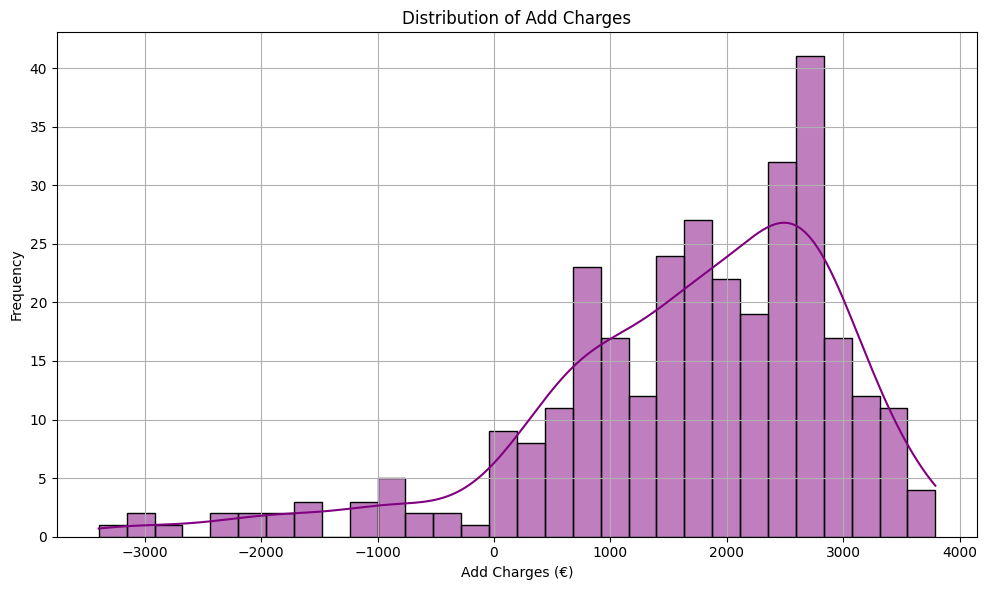

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(saved_customers['add_charges'], kde=True, color='purple', bins=30)
plt.title('Distribution of Add Charges')
plt.xlabel('Add Charges (€)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## Additional Tenure Distribution

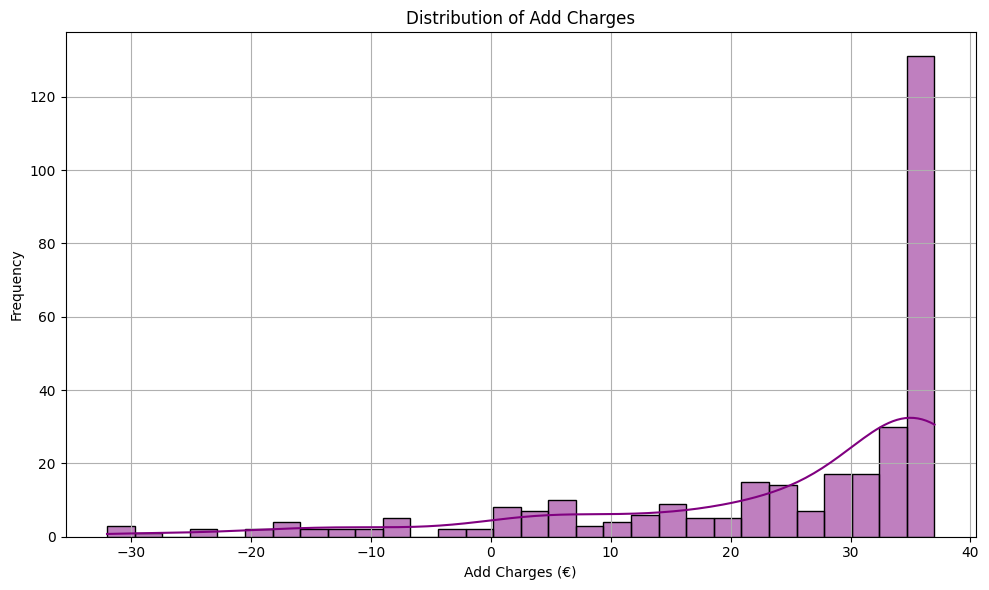

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(saved_customers['add_months'], kde=True, color='purple', bins=30)
plt.title('Distribution of Add Charges')
plt.xlabel('Add Charges (€)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted additional Revenues

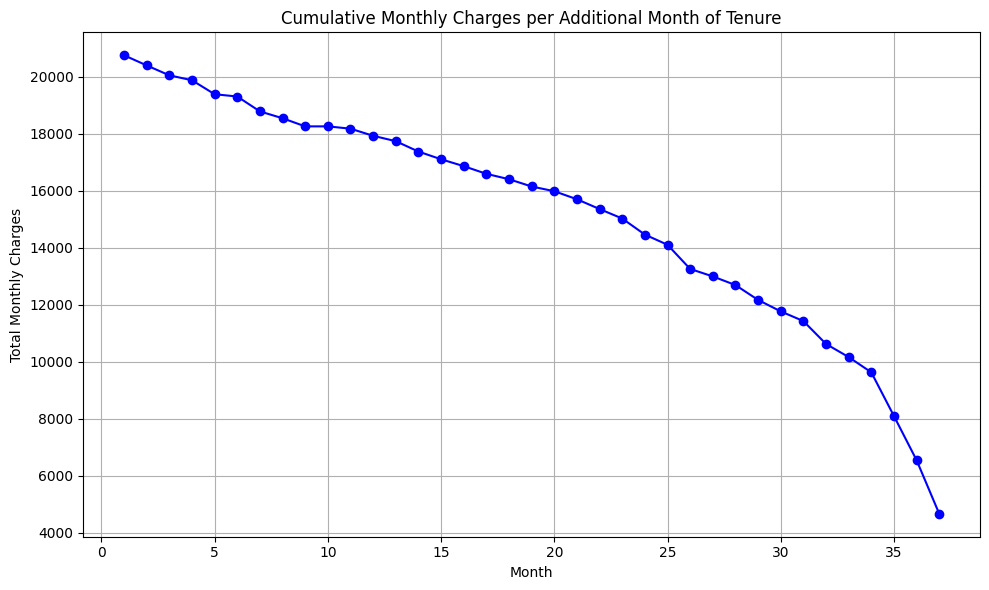

In [22]:
months = []
charges = []

# Loop through to accumulate clients charges across months
for _, row in saved_customers.iterrows():

    for month in range(1, int(row['add_months']) + 1):
        months.append(month)
        charges.append(row['MonthlyCharges'])

# create a dataframe
df_cumulative = pd.DataFrame({
    'Month': months,
    'MonthlyCharges': charges
})

# Group by month and calculate the monthly sum
df_monthly_sum = df_cumulative.groupby('Month')['MonthlyCharges'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_monthly_sum['Month'], df_monthly_sum['MonthlyCharges'], marker='o', color='b')
plt.title('Cumulative Monthly Charges per Additional Month of Tenure')
plt.xlabel('Month')
plt.ylabel('Total Monthly Charges')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# First year cumulative sum
df_monthly_sum[:12]

,Month,MonthlyCharges,CumulativeMonthlyCharges
0,1,20755.50,20755.50
1,2,20399.45,41154.95
2,3,20051.70,61206.65
3,4,19878.95,81085.60
4,5,19388.90,100474.50
5,6,19308.30,119782.80
6,7,18786.15,138568.95
7,8,18545.95,157114.90
8,9,18261.05,175375.95
9,10,18261.05,193637.00


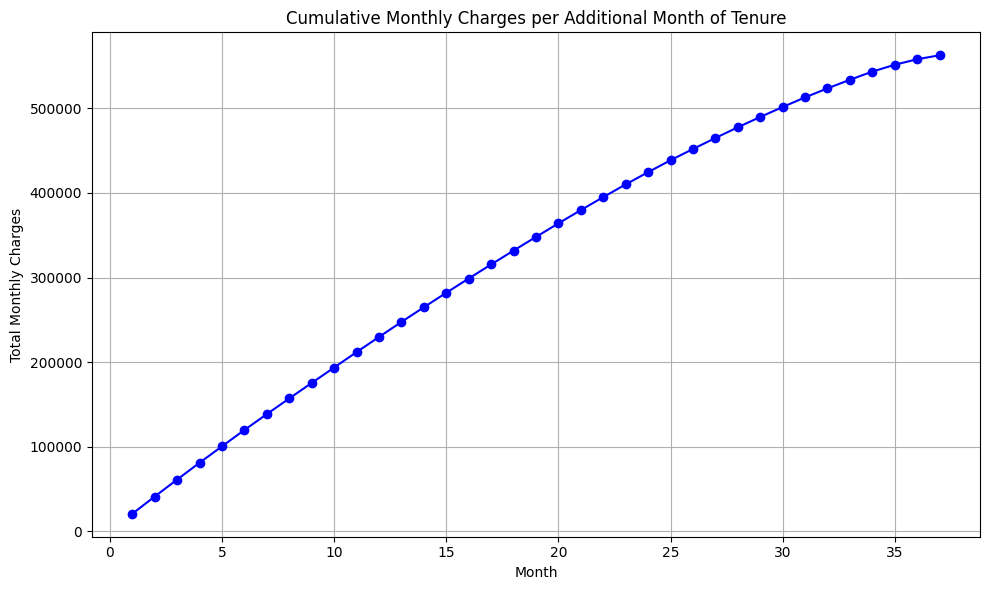

In [23]:
df_monthly_sum['CumulativeMonthlyCharges'] = df_monthly_sum['MonthlyCharges'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(df_monthly_sum['Month'], df_monthly_sum['CumulativeMonthlyCharges'], marker='o', color='b')
plt.title('Cumulative Monthly Charges per Additional Month of Tenure')
plt.xlabel('Month')
plt.ylabel('Total Monthly Charges')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
max_revenue = df_monthly_sum['CumulativeMonthlyCharges'].max()
max_months = df_monthly_sum['Month'].max()

print(f'The cumulative amount of additional Revenues is: € {max_revenue:.2f} within the next {max_months} months.')

The cumulative amount of additional Revenues is: € 562733.80 within the next 37 months.
